 # M2.1 Word Embeddings

 [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m2_2_embeddings.ipynb)
 [![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m2_2_embeddings.ipynb)

 ### Learning Objectives
 In this notebook, you will:
 1. Load and explore pre-trained word embeddings (Word2Vec)
 2. Understand the structure and properties of word vectors
 3. Implement similarity and analogy functions from scratch
 4. Visualize word embeddings in 2D space
 5. Learn to use the Gensim library for easy word embedding comparison
 6. Explore biases in word embeddings

 ---

 ## 1. Loading Word Embeddings
 We'll start by loading Word2Vec embeddings and examining their structure.
 This helps us understand that embeddings are simply:
 - **A vocabulary** (words/tokens)
 - **Vectors** (numerical representations for each word)

In [1]:
# ignore warning messages for cleaner output of the website
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import gensim.downloader
import os

In [2]:
def load_word2vec_raw(model_name='word2vec-google-news-300', limit=100000):
    """
    Load Word2Vec model and extract raw components.
    
    Args:
        model_name: Name of the pre-trained model
        limit: Maximum number of words to load (for memory efficiency)
    
    Returns:
        word2idx: Dictionary mapping words to indices
        index_to_word: Dictionary mapping indices to words
        embeddings: Numpy array of shape (vocab_size, embedding_dim)
    """
    print(f"Loading {model_name} model (first {limit} words)...")
    
    # Load the model using gensim
    model = gensim.downloader.load(model_name)
    
    # Extract vocabulary and vectors
    words = list(model.index_to_key[:limit])
    
    # Create mappings
    word2idx = {word: idx for idx, word in enumerate(words)}
    idx2word = {idx: word for idx, word in enumerate(words)}
    
    # Get embedding matrix
    embeddings = np.array([model[word] for word in words])
    
    print(f"Loaded {len(words)} words")
    print(f"Embedding dimension: {embeddings.shape[1]}")
    
    return word2idx, idx2word, embeddings

# Load the embeddings
word_to_idx, idx2word, embedding_matrix = load_word2vec_raw(limit=50000)


Loading word2vec-google-news-300 model (first 50000 words)...
Loaded 50000 words
Embedding dimension: 300


 ### Understanding the Data Structure



 Let's examine what we just loaded:

In [3]:
print("=" * 50)
print("EXAMINING THE EMBEDDING STRUCTURE")
print("=" * 50)

# 1. The embedding matrix
print(f"\n1. Embedding Matrix Shape: {embedding_matrix.shape}")
print(f"   - We have {embedding_matrix.shape[0]} words")
print(f"   - Each word is represented by {embedding_matrix.shape[1]} numbers")

# 2. Sample vocabulary
print(f"\n2. First 20 words in vocabulary:")
print([idx2word[i] for i in range(20)])

# 3. A single word vector
sample_word = "computer"
if sample_word in word_to_idx:
    vector = embedding_matrix[word_to_idx[sample_word]]
    print(f"\n3. Vector for '{sample_word}':")
    print(f"   Shape: {vector.shape}")
    print(f"   First 10 dimensions: {vector[:10]}")
    print(f"   Min value: {vector.min():.4f}, Max value: {vector.max():.4f}")
    print(f"   Mean: {vector.mean():.4f}, Std: {vector.std():.4f}")


EXAMINING THE EMBEDDING STRUCTURE

1. Embedding Matrix Shape: (50000, 300)
   - We have 50000 words
   - Each word is represented by 300 numbers

2. First 20 words in vocabulary:
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are']

3. Vector for 'computer':
   Shape: (300,)
   First 10 dimensions: [ 0.10742188 -0.20117188  0.12304688  0.21191406 -0.09130859  0.21679688
 -0.13183594  0.08300781  0.20214844  0.04785156]
   Min value: -0.5352, Max value: 0.4219
   Mean: -0.0125, Std: 0.1514


 ## 2. Computing Similarity Between Words
A key premise of word embedding is that **words with similar meanings have similar vectors**. However, when we compare vectors, there are different ways of looking at "similarity." A common approach is to compute the **cosine similarity** between them. For cosine similarity, we don't care how "long" a vector is, but rather in what direction it is pointing in the vector space. The cosine similarity calculates the angle between two vectors (which we measure via the cosine), so neglecting the length, it essentially asks: "how much should I rotate vector A so that it aligns with vector B?" In the figure below, we see a 2D vector space using three words: apple, banana, and boat. The cosine similarity between apple and banana is the angle between the two vectors. We also see that in vector space, if vectors are close to each other, they are often also semantically similar. But for now, let's put this to the test!

 $$\text{cosine similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{||\mathbf{A}|| \times ||\mathbf{B}||}$$

 <p align="center">
    <img src="https://www.researchgate.net/publication/341360737/figure/fig1/AS:890901874343942@1589418967903/The-angle-or-cosine-distance-between-words-along-two-dimensions-latent-factors.ppme" alt="kindqueen" style="max-width:20%;">
</p>

In [4]:
def cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two vectors or between a matrix of vectors and a single vector.

    Args:
        vec1: First vector (numpy array) or matrix of vectors (shape: [n, d])
        vec2: Second vector (numpy array, shape: [d])

    Returns:
        Similarity score(s) between -1 and 1.
        If vec1 is 1D, returns a scalar.
        If vec1 is 2D, returns a 1D array of similarities for each row in vec1, e.g. [sim_1, sim_2, ..., sim_n].
    """
    dot_product = np.dot(vec1, vec2)
    if vec1.ndim == 2:
        norm1 = np.linalg.norm(vec1, axis=1)
    else:
        norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)


In [5]:
# Test it out
word1, word2 = "computer", "laptop"
if word1 in word_to_idx and word2 in word_to_idx:
    vec1 = embedding_matrix[word_to_idx[word1]]
    vec2 = embedding_matrix[word_to_idx[word2]]
    
    similarity = cosine_similarity(vec1, vec2)
    print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")

# Compare with dissimilar words
word3 = "banana"
if word3 in word_to_idx:
    vec3 = embedding_matrix[word_to_idx[word3]]
    similarity2 = cosine_similarity(vec1, vec3)
    print(f"Similarity between '{word1}' and '{word3}': {similarity2:.4f}")


Similarity between 'computer' and 'laptop': 0.6640
Similarity between 'computer' and 'banana': 0.0908


 ### Exercise 1: Understanding Similarity Scores

 Try computing similarity between different word pairs. What do you notice?

In [6]:
# Compute similarities between these word pairs
word_pairs = [
    ("king", "queen"),
    ("king", "man"),
    ("king", "apple"),
    ("happy", "joyful"),
    ("happy", "sad"),
    ("car", "automobile"),
]

print("\nSimilarity scores for word pairs:")
print("-" * 50)
for w1, w2 in word_pairs:
    if w1 in word_to_idx and w2 in word_to_idx:
        v1 = embedding_matrix[word_to_idx[w1]]
        v2 = embedding_matrix[word_to_idx[w2]]
        sim = cosine_similarity(v1, v2)
        print(f"{w1:15} <-> {w2:15} : {sim:.4f}")



Similarity scores for word pairs:
--------------------------------------------------
king            <-> queen           : 0.6511
king            <-> man             : 0.2294
king            <-> apple           : 0.1083
happy           <-> joyful          : 0.4238
happy           <-> sad             : 0.5355
car             <-> automobile      : 0.5838


**Observation:**
- What do you see when you look at the cosine similarities between the different embeddings? semantically similar words have as expected a much higher similarity. However, we also see that words like "happy" and "sad" have a high similarity (even higher than "happy" and "joyful"), showing that antonyms do give high similarity scores as well. 

## 3. Finding Most Similar Words

Now let's implement a function to find the most similar words to a given word. This requires computing similarity with ALL words in vocabulary!



In [ ]:
def find_most_similar_embedding(target_vector, embeddings, idx2word, top_n=5, exclude_indices=None):
    """  Find most similar words to a target vector. (also used later on)  """

    #  Compute cosine similarities
    similarities = cosine_similarity(embeddings, target_vector)

    # Exclude specified indices by setting similarity to -inf
    if exclude_indices:
        similarities = similarities.copy()
        for idx in exclude_indices:
            if 0 <= idx < similarities.shape[0]:
                similarities[idx] = -np.inf

    top_indices = np.argsort(similarities)[::-1][:top_n]
    return [(idx2word[idx], similarities[idx]) for idx in top_indices]


def find_similar_words(word, word_to_idx, idx2word, embeddings, top_n=10):
    """    Find the most similar words to a given word.  """
    if word not in word_to_idx:
        print(f"'{word}' not found in vocabulary")
        return []
    
    # Get the vector for the input word
    word_vector = embeddings[word_to_idx[word]]
    
    # Use the helper function to find most similar embeddings
    exclude_idx = {word_to_idx[word]}
    results = find_most_similar_embedding(
        word_vector, embeddings, idx2word, top_n=top_n, exclude_indices=exclude_idx
    )
    
    return results

In [8]:
# Test the function
test_words = ["computer", "happy", "france"]

for word in test_words:
    if word in word_to_idx:
        print(f"\nMost similar words to '{word}':")
        print("-" * 50)
        similar_words = find_similar_words(word, word_to_idx, idx2word, 
                                         embedding_matrix, top_n=8)
        for similar_word, score in similar_words:
            print(f"  {similar_word:20} {score:.4f}")



Most similar words to 'computer':
--------------------------------------------------
  computers            0.7979
  laptop               0.6640
  laptop_computer      0.6549
  Computer             0.6473
  laptop_computers     0.5585
  PC                   0.5540
  laptops              0.5518
  PCs                  0.5517

Most similar words to 'happy':
--------------------------------------------------
  glad                 0.7409
  pleased              0.6632
  ecstatic             0.6627
  overjoyed            0.6599
  thrilled             0.6514
  satisfied            0.6438
  proud                0.6360
  delighted            0.6272


 ### Exercise 2: Explore Different Words

 Try finding similar words for terms from linguistics, your research, or daily life!

In [9]:
# TODO: Try adding your own words here
my_words = ["Friday", "Obama", "America", "Netherlands"]

for word in my_words:
    if word in word_to_idx:
        similar = find_similar_words(word, word_to_idx, idx2word, 
                                   embedding_matrix, top_n=5)
        print(f"- {word}: {[w for w, s in similar]}")
    else:
        print(f"Sorry could not find '{word}' in vocabulary.")


- Friday: ['Thursday', 'Monday', 'Wednesday', 'Tuesday', 'Saturday']
- Obama: ['Barack_Obama', 'President_Barack_Obama', 'McCain', 'Clinton', 'Illinois_senator']
- America: ['United_States', 'American', 'Europe', 'nation', 'world']
- Netherlands: ['Belgium', 'Dutch', 'Denmark', 'Germany', 'Sweden']


## 4. Vector Arithmetic and Analogies
One of the most fascinating properties of word embeddings:

**Semantic relationships are encoded as vector relationships!**

Check the illustration below, we have the four words "king", "queen", "man", "women". Via our word embeddings we obtain a vector for each word, which are illustrated as 2D vectors in the example below, but real word embeddings are much larger, e.g. 300 dimentions in the word2vec embeddings we are working with. While these vectors are trained based on the distributions they are trained on, they learned to encode complex semantic relationships too (see the original paper, ([Mikolov et al., 2013](https://aclanthology.org/N13-1090.pdf)) about this, it's a nice read :) ) . So when we take the vector of Man and substract the vector of Woman from it, we get a new vector which represents the difference between the two vectors, which in this case is mostly the gender of the word (and potential biases as we will see at the end of this notebook). To confirm this gender relationship we can do some analogy problems.

A famous analogy example using word embeddings:
- king - man + woman ≈ queen

<p align="center">
    <img src="https://pbs.twimg.com/media/F1pB0v7XoAEdKmm.jpg:large" alt="kindqueen" style="max-width:20%;">
</p>

Let's implement this from scratch!

In [10]:
def solve_analogy(word_a, word_b, word_c, word_to_idx, idx2word, 
                  embeddings, top_n=5):
    """
    Solve analogies: word_a is to word_b as word_c is to ???.
    Uses an inner helper to find most similar words to a target vector.
    """


    # Check vocabulary presence
    for word in [word_a, word_b, word_c]:
        if word not in word_to_idx:
            print(f"'{word}' not found in vocabulary")
            return []

    # Retrieve vectors
    vec_a = embeddings[word_to_idx[word_a]]
    vec_b = embeddings[word_to_idx[word_b]]
    vec_c = embeddings[word_to_idx[word_c]]

    # Analogy vector: vec_b - vec_a + vec_c
    target_vector = vec_b - vec_a + vec_c

    # Prepare exclude indices (exclude the three input words)
    exclude_indices = [word_to_idx[w] for w in [word_a, word_b, word_c]]

    # Use helper to get the most similar words
    results = find_most_similar_embedding(target_vector, embeddings, idx2word,
                                       top_n=top_n, exclude_indices=exclude_indices)
    return results


# Test with famous examples
print("ANALOGY TESTS")
print("=" * 50)

analogies = [
    ("king", "man", "queen"),  # king - man + queen ≈ woman
    ("Paris", "France", "Rome"),  # Paris - France + Rome ≈ Italy
    ("walking", "walked", "swimming"),  # walking - walked + swimming ≈ swam
]

for word_a, word_b, word_c in analogies:
    print(f"\n{word_a} is to {word_b} as {word_c} is to...?")
    results = solve_analogy(word_a, word_b, word_c, word_to_idx, 
                           idx2word, embedding_matrix, top_n=3)
    for word, score in results:
        print(f"  {word:15} ({score:.4f})")


ANALOGY TESTS

king is to man as queen is to...?
  woman           (0.7187)
  girl            (0.5883)
  lady            (0.5754)

Paris is to France as Rome is to...?
  Italy           (0.7115)
  Sicily          (0.5600)
  Italians        (0.5600)

walking is to walked as swimming is to...?
  swam            (0.7226)
  swim            (0.7098)
  swimmers        (0.6162)


**Observation**: We see for these few cases that the word embeddings capture very well the concept of royalty, the country-capital realtionship, and the concept of past tense!

## 5. Visualizing Word Embeddings

Word embeddings are 300-dimensional, and we poort humans can usually only see in 3D which makes vizualizing word embeddings a bit of a problem. To understand what is going on in this complex vector high dimensional vector space we have some tricks to rely on using  ✨ _dimensionality reduction_ ✨. Via dimensionality reduction methods we wish to reduce the 300D to 2D in a way that let's us retain some properties, such as how close points are in the original space. A popular method we will use is [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), but an alternative method [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is also relevant in other cases.

### What is t-SNE
t-SNE (t-Distributed Stochastic Neighbor Embedding) helps us visualize high-dimensional data by finding a 2D representation that preserves relationships between points. The key idea is that words that are similar in the original 300D space should appear close together in the 2D plot.

**Things you can interpret:**
- **Words close together are semantically related** : if "king" and "queen" are near each other, they share meaning
- **Clusters reveal semantic groups** : family words, countries, or emotions often form visible clusters
- **Local neighborhoods matter** : look at what words surround a specific word to understand its semantic context

**Things to be careful about:**
- **Distances between distant clusters are less meaningful** : t-SNE preserves local structure well, but the space between far-apart clusters doesn't tell you much
- **The axes don't mean anything specific** : unlike some other methods, x and y don't represent interpretable dimensions
- **Different runs can look different** : the same data might produce rotated or flipped plots, which is fine—focus on which words are grouped together, not their absolute positions

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_words_2d(words, word_to_idx, embeddings, figsize=(8, 5), color_map=None, legend_labels=None, return_fig=False):
    """
    Visualize word embeddings in 2D space with color coding.
    
    Args:
        words: List of words to visualize
        word_to_idx: Word to index mapping
        embeddings: Embedding matrix
        method: 'tsne' or 'pca'
        figsize: Figure size tuple
        color_map: List of colors for each word (optional)
        legend_labels: Dict mapping color to label for legend (optional)
    """
    valid_words = [w for w in words if w in word_to_idx]
    if len(valid_words) < 2:
        print("Not enough valid words to visualize")
        return

    vectors = np.array([embeddings[word_to_idx[w]] for w in valid_words])

    # We want to reduce it to a 2D plot, so set n_components=2
    reducer = TSNE(n_components=2, random_state=42, perplexity=min(5, len(valid_words)-1))

    vectors_2d = reducer.fit_transform(vectors)

    # Only create a new figure if return_fig is False (default single plot behavior)
    if return_fig is False:
        plt.figure(figsize=figsize)
    
    if color_map:
        for i, word in enumerate(valid_words):
            plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1], 
                        c=color_map[i], s=100, alpha=0.6)
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12, alpha=0.8)
        # Add legend
        if legend_labels:
            handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                                  markerfacecolor=color, markersize=10)
                       for color, label in legend_labels.items()]
            plt.legend(handles=handles)
    else:
        plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6, s=100)
        for i, word in enumerate(valid_words):
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12, alpha=0.8)

    plt.title(f"Word Embeddings Visualization (TSNE)", fontsize=14)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True, alpha=0.3)
    
    # Only call tight_layout and show if this is a standalone plot
    if return_fig is False:
        plt.tight_layout()
        plt.show()
    elif return_fig is True:
        return plt.gcf()



Visualizing family relationships:


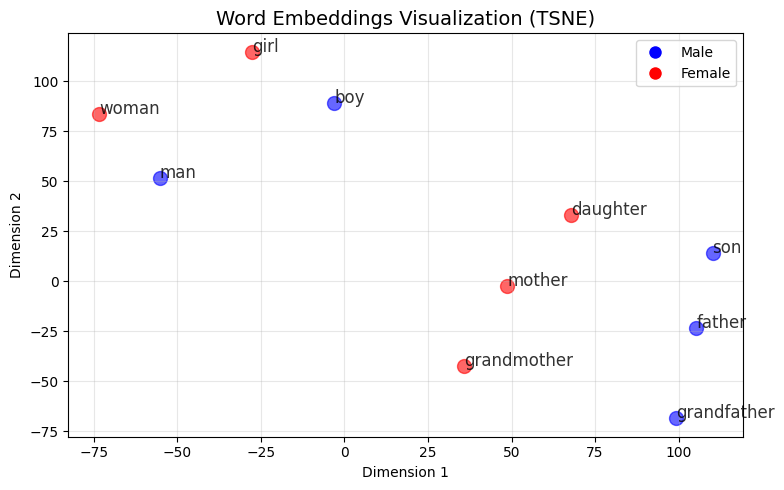

In [12]:
# Example: Visualize family relationships with gender color
print("Visualizing family relationships:")
family_words = ["man", "woman", "boy", "girl", "father", "mother", 
                "son", "daughter", "grandfather", "grandmother"]
family_colors = ['blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']
family_legend = {'blue': 'Male', 'red': 'Female'}
visualize_words_2d(family_words, word_to_idx, embedding_matrix, color_map=family_colors, legend_labels=family_legend)



**Observation**:
- We see that for these family relationships the t-SNE plot highlights some clear patterns:
    1. The gender relationship is very consistent, for each family relationship, the male variant is to the bottom-right of the female variant. 
    2. Moreover, the more family terms: son, mother etc, are in a separate cluster (bottom right) than the less family related terms (top left): woman, man, boy, girl. 
    3. For the family terms we also see a nice order, first grandmother, then mother, then dauther.

**Q:** What other relationship patterns do you see?


Visualizing countries and capitals - side by side comparison:


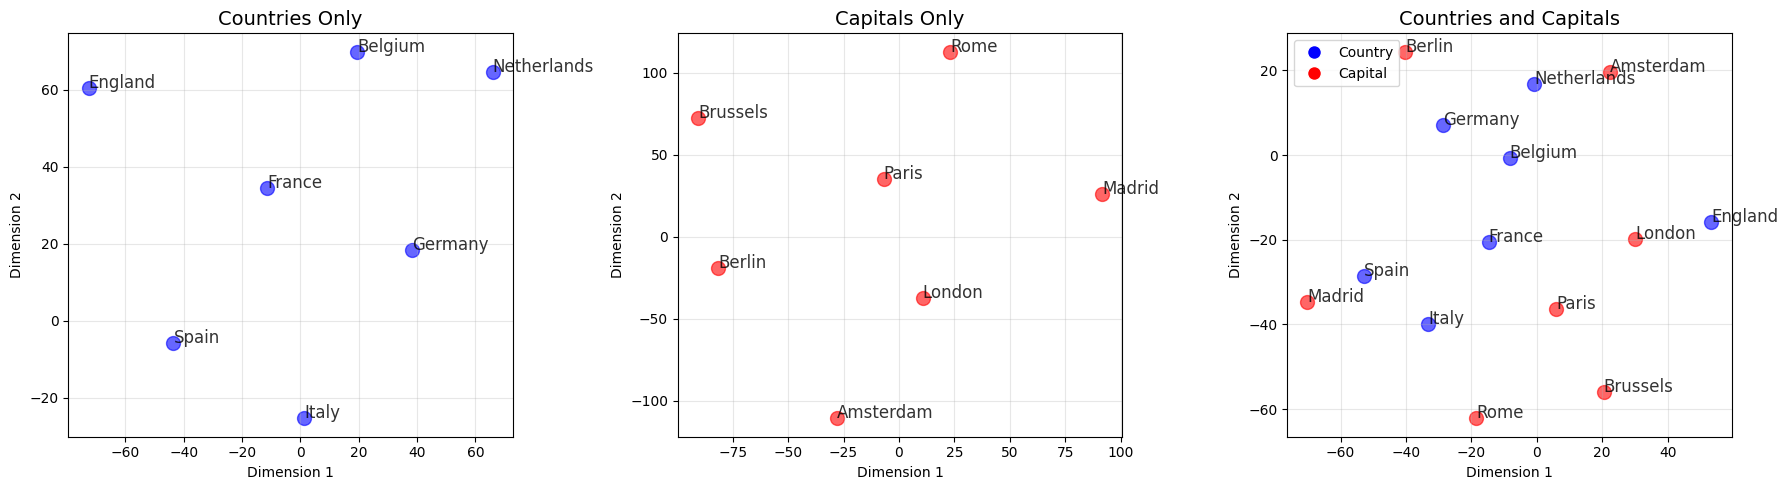

In [13]:
print("\nVisualizing countries and capitals - side by side comparison:")

# Define countries and capitals separately
countries = ["France", "Germany", "Italy", "Spain", "England", "Netherlands", "Belgium"]
capitals = ["Paris", "Berlin", "Rome", "Madrid", "London", "Amsterdam", "Brussels"]

# Create 3 separate plots
fig = plt.figure(figsize=(18, 5))

# Plot 1: Countries only (blue)
plt.subplot(1, 3, 1)
visualize_words_2d(countries, word_to_idx, embedding_matrix, 
                   color_map=['blue']*len(countries), return_fig=True)
plt.title("Countries Only", fontsize=14)

# Plot 2: Capitals only (red)
plt.subplot(1, 3, 2)
visualize_words_2d(capitals, word_to_idx, embedding_matrix, 
                   color_map=['red']*len(capitals), return_fig=True)
plt.title("Capitals Only", fontsize=14)

# Plot 3: Both together (with legend)
plt.subplot(1, 3, 3)
geo_words = countries + capitals
geo_colors = ['blue'] * len(countries) + ['red'] * len(capitals)
geo_legend = {'blue': 'Country', 'red': 'Capital'}
visualize_words_2d(geo_words, word_to_idx, embedding_matrix, 
                   color_map=geo_colors, legend_labels=geo_legend, return_fig=True)
plt.title("Countries and Capitals", fontsize=14)

plt.tight_layout()
plt.show()

**Observation**:
- Keep in mind that each time the t-SNE plot is generated the direction can change. 
- For the capitals and countries we see some geographical information: the netherlands is closest to belgium, germany and then france. 
- When visualizing the capitals and countries via t-SNE we already see some limitations of this method. There are many structures in the data now: geographical (where on the map it is), relational (the fact a capital is in a country). For many of the country capitals here we do see that the closest city to a country is it's capital (except for Belgium).  

 ## 6. Using the Gensim Library (Faster Package)
 Now that you understand what's happening under the hood, let's see how to use the Gensim library for production work. It's much faster and has more features!

In [14]:
import gensim.downloader

# Load model with Gensim wrapper
print("Loading model with Gensim KeyedVectors...")
model = gensim.downloader.load('word2vec-google-news-300')

print(f"\nModel vocabulary size: {len(model)}")
print(f"Embedding dimensions: {model.vector_size}")


Loading model with Gensim KeyedVectors...

Model vocabulary size: 3000000
Embedding dimensions: 300


 ### Common Operations with KeyedVectors

In [15]:
# 1. Finding similar words
print("\n1. Most similar words to 'computer':")
similar = model.most_similar('computer', topn=5)
for word, score in similar:
    print(f"   {word}: {score:.4f}")

# 2. Computing similarity
print("\n2. Similarity between words:")
print(f"   computer <-> laptop: {model.similarity('computer', 'laptop'):.4f}")
print(f"   computer <-> banana: {model.similarity('computer', 'banana'):.4f}")

# 3. Solving analogies
print("\n3. Analogy: king - man + woman =")
result = model.most_similar(positive=['king', 'woman'], 
                            negative=['man'], topn=3)
for word, score in result:
    print(f"   {word}: {score:.4f}")

# 4. Finding odd one out
print("\n4. Which word doesn't match?")
words = ['breakfast', 'lunch', 'dinner', 'car']
oddone = model.doesnt_match(words)
print(f"   Words: {words}")
print(f"   Odd one out: {oddone}")

# 5. Get vector for a word
print("\n5. Accessing word vector:")
vector = model['computer']
print(f"   Shape: {vector.shape}")
print(f"   First 5 values: {vector[:5]}")



1. Most similar words to 'computer':
   computers: 0.7979
   laptop: 0.6640
   laptop_computer: 0.6549
   Computer: 0.6473
   com_puter: 0.6082

2. Similarity between words:
   computer <-> laptop: 0.6640
   computer <-> banana: 0.0908

3. Analogy: king - man + woman =
   queen: 0.7118
   monarch: 0.6190
   princess: 0.5902

4. Which word doesn't match?
   Words: ['breakfast', 'lunch', 'dinner', 'car']
   Odd one out: car

5. Accessing word vector:
   Shape: (300,)
   First 5 values: [ 0.10742188 -0.20117188  0.12304688  0.21191406 -0.09130859]


 ## 7. Exploring Biases in Word Embeddings
 Word embeddings learn from text data, which reflects societal biases. Let's investigate gender bias in our embeddings.

GENDER BIAS ANALYSIS

1. Words most associated with 'he' vs 'she':
------------------------------------------------------------
Occupation      Similarity to HE     Similarity to SHE    Difference     
------------------------------------------------------------
doctor          0.2744               0.2774               -0.0030    neutral
nurse           0.1223               0.3694               -0.2471    → SHE
engineer        0.1076               0.0033               0.1044     → HE
teacher         0.1609               0.2819               -0.1210    → SHE
programmer      0.0702               0.0691               0.0012     neutral
secretary       0.0891               0.0978               -0.0087    neutral
CEO             -0.0199              -0.0980              0.0781     → HE
assistant       0.1251               0.1221               0.0030     neutral
scientist       0.0709               0.0720               -0.0012    neutral
homemaker       0.1307               0.3984           

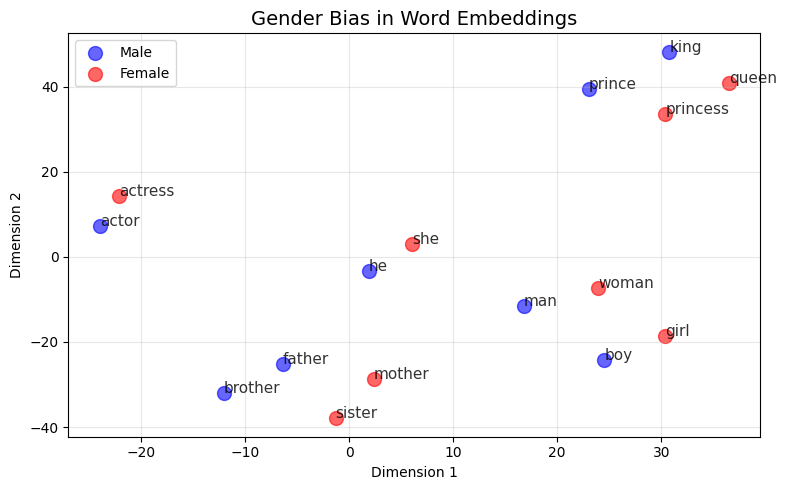

In [16]:
def explore_gender_bias(model):
    """
    Explore gender bias in word embeddings.
    """
    print("GENDER BIAS ANALYSIS")
    print("=" * 60)
    
    # 1. Direct gender associations
    print("\n1. Words most associated with 'he' vs 'she':")
    print("-" * 60)

    # Occupations to test
    occupations = ['doctor', 'nurse', 'engineer', 'teacher', 
                   'programmer', 'secretary', 'CEO', 'assistant',
                   'scientist', 'homemaker', 'professor', 'receptionist']
    
    print(f"{'Occupation':<15} {'Similarity to HE':<20} {'Similarity to SHE':<20} {'Difference':<15}")
    print("-" * 60)
    
    for occupation in occupations:
        if occupation in model:
            sim_he = model.similarity(occupation, 'he')
            sim_she = model.similarity(occupation, 'she')
            diff = sim_he - sim_she
            
            bias_marker = "→ HE" if diff > 0.01 else "→ SHE" if diff < -0.01 else "neutral"
            print(f"{occupation:<15} {sim_he:<20.4f} {sim_she:<20.4f} {diff:<10.4f} {bias_marker}")
    
    # 2. Analogy-based bias
    print("\n\n2. Gender analogies:")
    print("-" * 60)
    
    # Test: man is to X as woman is to Y
    male_terms = ['king', 'prince', 'father', 'brother', 'actor', 'hero']
    
    for male_term in male_terms:
        if male_term in model:
            # Find: man - male_term + woman = ?
            results = model.most_similar(positive=['woman', male_term], 
                                        negative=['man'], topn=3)
            print(f"\nman:{male_term} :: woman:?")
            for word, score in results:
                print(f"   {word} ({score:.4f})")
    
    # 3. Visualization of gendered words
    print("\n\n3. Visualizing gendered word space:")
    gendered_words = ['he', 'she', 'man', 'woman', 'king', 'queen',
                      'father', 'mother', 'boy', 'girl', 'actor', 'actress',
                      'brother', 'sister', 'prince', 'princess']
    
    gendered_words = [w for w in gendered_words if w in model]
    
    # Get vectors
    vectors = np.array([model[w] for w in gendered_words])
    
    # Reduce to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    vectors_2d = tsne.fit_transform(vectors)
    
    # Plot with color coding
    plt.figure(figsize=(8, 5))
    
    male_indices = [i for i, w in enumerate(gendered_words) 
                    if w in ['he', 'man', 'king', 'father', 'boy', 'actor', 'brother', 'prince']]
    female_indices = [i for i, w in enumerate(gendered_words) 
                      if w in ['she', 'woman', 'queen', 'mother', 'girl', 'actress', 'sister', 'princess']]
    
    plt.scatter(vectors_2d[male_indices, 0], vectors_2d[male_indices, 1], 
               c='blue', label='Male', alpha=0.6, s=100)
    plt.scatter(vectors_2d[female_indices, 0], vectors_2d[female_indices, 1], 
               c='red', label='Female', alpha=0.6, s=100)
    
    for i, word in enumerate(gendered_words):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                    fontsize=11, alpha=0.8)
    
    plt.title("Gender Bias in Word Embeddings", fontsize=14)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the bias analysis
explore_gender_bias(model)


**Observation questions:**
 - Are certain professions more associated with one gender?
 - Do the analogies reveal stereotypical associations?
 - What are the implications for using these embeddings in NLP systems?
 - How might we address these biases?

## 8. Practical Application - Building a Simple Semantic Search
 Let's build a simple semantic search engine that finds relevant documents based on meaning rather than exact keyword matching.

In [17]:
def simple_semantic_search(query, documents, model, top_k=3):
    """
    Search documents based on semantic similarity to query.
    
    Args:
        query: Search query string
        documents: List of document strings
        model: Word2Vec model
        top_k: Number of top results to return
    
    Returns:
        List of (doc_index, similarity_score) tuples
    """
    def get_document_vector(text, model):
        """Average word vectors in a document."""
        words = text.lower().split()
        vectors = []
        for word in words:
            if word in model:
                vectors.append(model[word])
        
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(model.vector_size)
    
    # Get query vector
    query_vector = get_document_vector(query, model)
    
    # Compute similarity with each document
    similarities = []
    for i, doc in enumerate(documents):
        doc_vector = get_document_vector(doc, model)
        
        # Compute cosine similarity
        if np.linalg.norm(query_vector) > 0 and np.linalg.norm(doc_vector) > 0:
            similarity = np.dot(query_vector, doc_vector) / (
                np.linalg.norm(query_vector) * np.linalg.norm(doc_vector)
            )
        else:
            similarity = 0
        
        similarities.append((i, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    return similarities[:top_k]

# Example documents
documents = [
    "Machine learning algorithms can learn patterns from data without explicit programming",
    "Natural language processing helps computers understand and generate human language",
    "Python is a popular programming language for data science and artificial intelligence",
    "Deep neural networks have revolutionized computer vision and speech recognition",
    "The weather today is sunny with a high of 25 degrees celsius",
    "Cooking pasta requires boiling water and adding salt for flavor",
    "Linguistics studies the structure and evolution of human language",
    "Phonology examines the sound systems of languages across cultures"
]

# Test queries
queries = [
    "AI and machine learning",
    "studying language structure",
    "how to cook food"
]

print("SEMANTIC SEARCH DEMONSTRATION")
print("=" * 60)

for query in queries:
    print(f"\nQuery: '{query}'")
    print("-" * 60)
    
    results = simple_semantic_search(query, documents, model, top_k=3)
    
    for rank, (doc_idx, score) in enumerate(results, 1):
        print(f"\n{rank}. [Score: {score:.4f}]")
        print(f"   {documents[doc_idx]}")


SEMANTIC SEARCH DEMONSTRATION

Query: 'AI and machine learning'
------------------------------------------------------------

1. [Score: 0.5282]
   Machine learning algorithms can learn patterns from data without explicit programming

2. [Score: 0.4628]
   Natural language processing helps computers understand and generate human language

3. [Score: 0.3853]
   Phonology examines the sound systems of languages across cultures

Query: 'studying language structure'
------------------------------------------------------------

1. [Score: 0.7582]
   Linguistics studies the structure and evolution of human language

2. [Score: 0.6005]
   Natural language processing helps computers understand and generate human language

3. [Score: 0.5619]
   Phonology examines the sound systems of languages across cultures

Query: 'how to cook food'
------------------------------------------------------------

1. [Score: 0.6168]
   Cooking pasta requires boiling water and adding salt for flavor

2. [Score: 0

 **Observations**
 - Notice how the search finds relevant documents even without exact keyword matches
 - "AI and machine learning" finds documents about neural networks and algorithms
 - "studying language structure" finds linguistics-related documents
 - This is the foundation of modern semantic search engines!

## Self-Check Questions
1.  What are word embeddings and how do they represent words? 
2.  How can you measure similarity between two words using their embeddings? 
3.  What does vector arithmetic (e.g., king - man + woman) reveal about semantic relationships? 
4.  Why do word embeddings sometimes reflect biases present in training data? 
5.  How can dimensionality reduction techniques help us understand word embeddings? What are their limitations? 
6.  What are some practical applications of word embeddings in NLP? 
7.  How might you detect biases in word embeddings? 

## Ideas for personal experiments
- Try different words and analogies with your domain of interest
- Explore embeddings in other languages
- Investigate different types of biases (racial, cultural, etc.)
- Learn about newer embedding methods (GloVe, FastText, contextual embeddings like BERT)
- Build a more sophisticated semantic search system

## References
- Mikolov et al. (2013). "Efficient Estimation of Word Representations in Vector Space"
- Bolukbasi et al. (2016). "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"
- Gensim documentation: https://radimrehurek.com/gensim/